In [2]:
import pandas as pd

#데이터셋 불러오기
df = pd.read_csv("netflix_reviews.csv")

# 데이터셋 크기와 열 정보 출력|
print(f"Shape of the dataset: {df.shape}")
print(f"Columns in the dataset: {df.columns}")

Shape of the dataset: (117040, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    pattern = r'[^a-zA-Z가-힣]'
    text = re.sub(r'[^a-zA-Z\s.!?,]', '', text)  # 알파벳, 공백, 그리고 일부 구두점만 유지
    return text

# 불필요한 열 제거
df = df[['content', 'score']]

# 리뷰 텍스트 정제
df['content'] = df['content'].apply(preprocess_text)

# 불용어 제거
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['content'] = df['content'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


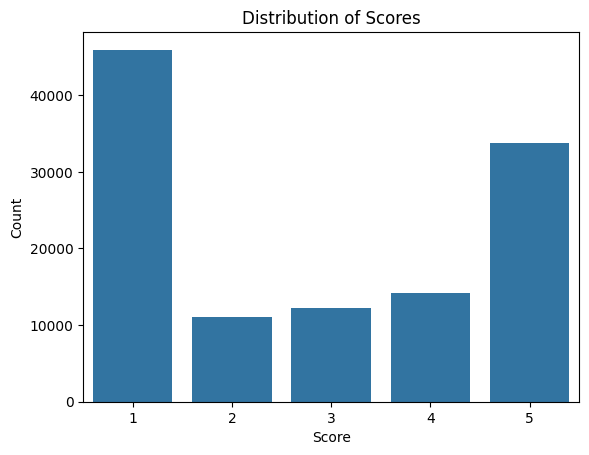

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 리뷰 점수 분포 확인
sns.countplot(x='score', data=df)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator
import nltk
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')

# 데이터 준비 (리뷰와 평점 컬럼을 추출)
reviews = df['content']
ratings = df['score']

# 훈련 및 테스트 데이터 분할 (train_test_split 사용)
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(reviews, ratings, test_size=0.3, random_state=42)

# 인덱스 초기화 (데이터 프레임 인덱스 리셋)
train_reviews.reset_index(drop=True, inplace=True)
train_ratings.reset_index(drop=True, inplace=True)
test_reviews.reset_index(drop=True, inplace=True)
test_ratings.reset_index(drop=True, inplace=True)

# 단어 사전 구축 함수 정의 (리뷰 텍스트를 토큰화하고 사전 생성)
def build_vocab(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])  # 알 수 없는 단어 처리
    return vocab

# 데이터셋 클래스 정의 (데이터셋을 커스텀하여 사용하기 위해 클래스 정의)
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return review, rating

# 패딩과 텐서 변환을 위한 collate 함수 정의
def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 배치에서 리뷰와 레이팅 분리
    reviews_padded = pad_sequence(reviews, batch_first=True)  # 리뷰를 패딩
    ratings_tensor = torch.tensor(ratings, dtype=torch.long)  # 레이팅을 텐서로 변환
    return reviews_padded, ratings_tensor  # 패딩된 리뷰와 레이팅 반환

# 단어 사전 생성 (훈련 데이터 리뷰를 기반으로 어휘 사전 구축)
vocab = build_vocab(train_reviews)

# 텍스트 파이프라인 정의 (텍스트를 토큰화하고 텐서로 변환)
def text_pipeline(text):
    tokenized = word_tokenize(text)  # 토큰화
    return torch.tensor([vocab[token] for token in tokenized], dtype=torch.long)

# 레이블 파이프라인 클래스 정의 (평점을 수치화하여 모델에 입력)
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

# 레이블 파이프라인 초기화 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 데이터셋 정의 (훈련 및 테스트 데이터셋 구성)
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의 (DataLoader를 통해 배치로 데이터를 로딩)
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 모델 정의 (LSTM 모델 구조를 설정하여 시퀀스 처리 수행)
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=True, padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, output_dim)
)

  # 순전파 정의 (입력 텍스트를 임베딩하고 LSTM과 FC 계층에 통과)
  def forward(self, text):
    embedded = self.embedding(text)
    output, (hidden, cell) = self.lstm(embedded)  # 배치 사이즈에 맞게 차원 추가
    return self.fc(hidden[-1].view(hidden.size(1), -1))

# 하이퍼파라미터 정의 (어휘 크기, 임베딩 차원, LSTM 은닉 차원 및 출력 차원 설정)
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5

# 모델 초기화 (LSTM 모델 인스턴스 생성)
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의 (교차 엔트로피 손실과 SGD 사용)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 모델 학습 과정 정의 (에포크 동안 훈련 데이터에 대해 손실 계산 및 가중치 업데이트)
def train_model(model, train_dataloader, optimizer, criterion, epochs=10):
    model.train()  # 모델을 학습 모드로 전환
    for epoch in range(epochs):
        total_loss = 0

        for batch in train_dataloader:
            reviews, ratings = batch  # 배치 데이터

            # reviews와 ratings를 안전하게 복사
            reviews = reviews.clone().detach()
            ratings = ratings.clone().detach()

            optimizer.zero_grad()  # 옵티마이저 초기화

            # 모델의 출력
            output = model(reviews)

            # 손실 계산 및 역전파
            loss = criterion(output, ratings)
            loss.backward()  # 그라디언트 계산
            optimizer.step()  # 옵티마이저를 통한 파라미터 업데이트

            total_loss += loss.item()

# 모델 학습 (훈련 함수 호출하여 모델 학습)
train_model(model, train_dataloader, optimizer, criterion, epochs=10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# 모델 평가 함수
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for reviews, labels in loader:
            outputs = model(reviews)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 모델 평가
accuracy = evaluate(model, test_dataloader)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6066


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator
import nltk
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')

# 데이터 준비 (리뷰와 평점 컬럼을 추출)
reviews = df['content']
ratings = df['score']

# 훈련 및 테스트 데이터 분할 (train_test_split 사용)
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(reviews, ratings, test_size=0.3, random_state=42)

# 인덱스 초기화 (데이터 프레임 인덱스 리셋)
train_reviews.reset_index(drop=True, inplace=True)
train_ratings.reset_index(drop=True, inplace=True)
test_reviews.reset_index(drop=True, inplace=True)
test_ratings.reset_index(drop=True, inplace=True)

# 단어 사전 구축 함수 정의 (리뷰 텍스트를 토큰화하고 사전 생성)
def build_vocab(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])  # 알 수 없는 단어 처리
    return vocab

# 데이터셋 클래스 정의 (데이터셋을 커스텀하여 사용하기 위해 클래스 정의)
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return review, rating

# 패딩과 텐서 변환을 위한 collate 함수 정의
def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 배치에서 리뷰와 레이팅 분리
    reviews_padded = pad_sequence(reviews, batch_first=True)  # 리뷰를 패딩
    ratings_tensor = torch.tensor(ratings, dtype=torch.long)  # 레이팅을 텐서로 변환
    return reviews_padded, ratings_tensor  # 패딩된 리뷰와 레이팅 반환

# 단어 사전 생성 (훈련 데이터 리뷰를 기반으로 어휘 사전 구축)
vocab = build_vocab(train_reviews)

# 텍스트 파이프라인 정의 (텍스트를 토큰화하고 텐서로 변환)
def text_pipeline(text):
    tokenized = word_tokenize(text)  # 토큰화
    return torch.tensor([vocab[token] for token in tokenized], dtype=torch.long)

# 레이블 파이프라인 클래스 정의 (평점을 수치화하여 모델에 입력)
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

# 레이블 파이프라인 초기화 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 데이터셋 정의 (훈련 및 테스트 데이터셋 구성)
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의 (DataLoader를 통해 배치로 데이터를 로딩)
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 모델 정의 (LSTM 모델 구조를 설정하여 시퀀스 처리 수행)
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=True, padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, output_dim)
)

  # 순전파 정의 (입력 텍스트를 임베딩하고 LSTM과 FC 계층에 통과)
  def forward(self, text):
    embedded = self.embedding(text)
    output, (hidden, cell) = self.lstm(embedded)  # 배치 사이즈에 맞게 차원 추가
    return self.fc(hidden[-1].view(hidden.size(1), -1))

# 하이퍼파라미터 정의 (어휘 크기, 임베딩 차원, LSTM 은닉 차원 및 출력 차원 설정)
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 예측할 점수 개수

# 모델 초기화 (LSTM 모델 인스턴스 생성)
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의 (교차 엔트로피 손실과 SGD 사용, 학습률 0.001로 설정)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 모델 학습 과정 정의 (에포크 동안 훈련 데이터에 대해 손실 계산 및 가중치 업데이트)
def train_model(model, train_dataloader, optimizer, criterion, epochs=10):
    model.train()  # 모델을 학습 모드로 전환
    for epoch in range(epochs):
        total_loss = 0

        for batch in train_dataloader:
            reviews, ratings = batch  # 배치 데이터

            # reviews와 ratings를 안전하게 복사
            reviews = reviews.clone().detach()
            ratings = ratings.clone().detach()

            optimizer.zero_grad()  # 옵티마이저 초기화

            # 모델의 출력
            output = model(reviews)

            # 손실 계산 및 역전파
            loss = criterion(output, ratings)
            loss.backward()  # 그라디언트 계산
            optimizer.step()  # 옵티마이저를 통한 파라미터 업데이트

            total_loss += loss.item()

# 모델 학습 (훈련 함수 호출하여 모델 학습)
train_model(model, train_dataloader, optimizer, criterion, epochs=10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# 모델 평가
accuracy = evaluate(model, test_dataloader)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4573


## [ 실험 결과 ]
### [ 기본 : 간단한 LSTM 모델 (학습률 = 0.01) ]
-> **정확도** = 0.6066
### [ 기본 : 간단한 LSTM 모델 (학습률 = 0.001) ]
-> **정확도** = 0.4573
### [ 결론 ]
-> 학습률을 0.01로 설정하는 것이 더 성능이 좋게 나옴

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator
import nltk
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')

# 데이터 준비 (리뷰와 평점 컬럼을 추출)
reviews = df['content']
ratings = df['score']

# 훈련 및 테스트 데이터 분할 (train_test_split 사용)
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(reviews, ratings, test_size=0.3, random_state=42)

# 인덱스 초기화 (데이터 프레임 인덱스 리셋)
train_reviews.reset_index(drop=True, inplace=True)
train_ratings.reset_index(drop=True, inplace=True)
test_reviews.reset_index(drop=True, inplace=True)
test_ratings.reset_index(drop=True, inplace=True)

# 단어 사전 구축 함수 정의 (리뷰 텍스트를 토큰화하고 사전 생성)
def build_vocab(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])  # 알 수 없는 단어 처리
    return vocab

# 데이터셋 클래스 정의 (데이터셋을 커스텀하여 사용하기 위해 클래스 정의)
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return review, rating

# 패딩과 텐서 변환을 위한 collate 함수 정의
def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 배치에서 리뷰와 레이팅 분리
    reviews_padded = pad_sequence(reviews, batch_first=True)  # 리뷰를 패딩
    ratings_tensor = torch.tensor(ratings, dtype=torch.long)  # 레이팅을 텐서로 변환
    return reviews_padded, ratings_tensor  # 패딩된 리뷰와 레이팅 반환

# 단어 사전 생성 (훈련 데이터 리뷰를 기반으로 어휘 사전 구축)
vocab = build_vocab(train_reviews)

# 텍스트 파이프라인 정의 (텍스트를 토큰화하고 텐서로 변환)
def text_pipeline(text):
    tokenized = word_tokenize(text)  # 토큰화
    return torch.tensor([vocab[token] for token in tokenized], dtype=torch.long)

# 레이블 파이프라인 클래스 정의 (평점을 수치화하여 모델에 입력)
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

# 레이블 파이프라인 초기화 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 데이터셋 정의 (훈련 및 테스트 데이터셋 구성)
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의 (DataLoader를 통해 배치로 데이터를 로딩)
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 모델 정의 (LSTM 모델 구조를 설정하여 시퀀스 처리 수행)
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, output_dim)
)

  # 순전파 정의 (입력 텍스트를 임베딩하고 LSTM과 FC 계층에 통과)
  def forward(self, text):
    embedded = self.embedding(text)
    output, (hidden, cell) = self.lstm(embedded)  # 배치 사이즈에 맞게 차원 추가
    return self.fc(hidden[-1].view(hidden.size(1), -1))

# 하이퍼파라미터 정의 (어휘 크기, 임베딩 차원, LSTM 은닉 차원 및 출력 차원 설정)
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 예측할 점수 개수

# 모델 초기화 (LSTM 모델 인스턴스 생성)
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의 (교차 엔트로피 손실과 Adam 사용, 학습률 0.01로 설정)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 모델 학습 과정 정의 (에포크 동안 훈련 데이터에 대해 손실 계산 및 가중치 업데이트)
def train_model(model, train_dataloader, optimizer, criterion, epochs=10):
    model.train()  # 모델을 학습 모드로 전환
    for epoch in range(epochs):
        total_loss = 0

        for batch in train_dataloader:
            reviews, ratings = batch  # 배치 데이터

            # reviews와 ratings를 안전하게 복사
            reviews = reviews.clone().detach()
            ratings = ratings.clone().detach()

            optimizer.zero_grad()  # 옵티마이저 초기화

            # 모델의 출력
            output = model(reviews)

            # 손실 계산 및 역전파
            loss = criterion(output, ratings)
            loss.backward()  # 그라디언트 계산
            optimizer.step()  # 옵티마이저를 통한 파라미터 업데이트

            total_loss += loss.item()

# 모델 학습 (훈련 함수 호출하여 모델 학습)
train_model(model, train_dataloader, optimizer, criterion, epochs=10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# 모델 평가
accuracy = evaluate(model, test_dataloader)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6349


## [ 실험 결과 ]
### [ 기본 : 간단한 LSTM 모델 (SGD 옵티마이저)]
-> **정확도** = 0.6066
### [ Adam 옵티마이저 ]
-> **정확도** = 0.6349
### [ 결론 ]
-> Adam 옵티마이저를 사용하는 것이 더 좋은 성능을 보임

In [14]:
# 실험 3 : 조기종료 사용
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator
import nltk
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')

# 데이터 준비 (리뷰와 평점 컬럼을 추출)
reviews = df['content']
ratings = df['score']

# 데이터 분할
# 훈련 데이터와 임시 데이터(검증 + 테스트 데이터) 분리(train_test_split 사용)
train_reviews, temp_reviews, train_ratings, temp_ratings = train_test_split(reviews, ratings, test_size=0.3, random_state=42)

# 임시 데이터를 검증 데이터와 테스트 데이터로 분리(train_test_split 사용)
test_reviews, rtest_reviews, test_ratings, rtest_ratings = train_test_split(temp_reviews, temp_ratings, test_size=0.5, random_state=42)

# 인덱스 초기화 (데이터 프레임 인덱스 리셋)
train_reviews.reset_index(drop=True, inplace=True)
train_ratings.reset_index(drop=True, inplace=True)
test_reviews.reset_index(drop=True, inplace=True)
test_ratings.reset_index(drop=True, inplace=True)
rtest_reviews.reset_index(drop=True, inplace=True)
rtest_ratings.reset_index(drop=True, inplace=True)

# 단어 사전 구축 함수 정의 (리뷰 텍스트를 토큰화하고 사전 생성)
def build_vocab(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])  # 알 수 없는 단어 처리
    return vocab

# 데이터셋 클래스 정의 (데이터셋을 커스텀하여 사용하기 위해 클래스 정의)
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return review, rating  # tensor로 변환하지 않음

# 패딩과 텐서 변환을 위한 collate 함수 정의
def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 배치에서 리뷰와 레이팅 분리
    reviews_padded = pad_sequence(reviews, batch_first=True)  # 리뷰를 패딩
    ratings_tensor = torch.tensor(ratings, dtype=torch.long)  # 레이팅을 텐서로 변환
    return reviews_padded, ratings_tensor  # 패딩된 리뷰와 레이팅 반환

# 단어 사전 생성 (훈련 데이터 리뷰를 기반으로 어휘 사전 구축)
vocab = build_vocab(train_reviews)

# 텍스트 파이프라인 정의 (텍스트를 토큰화하고 텐서로 변환)
def text_pipeline(text):
    tokenized = word_tokenize(text)  # 토큰화
    return torch.tensor([vocab[token] for token in tokenized], dtype=torch.long)  # 텐서를 LongTensor로 변환

# 레이블 파이프라인 클래스 정의 (평점을 수치화하여 모델에 입력)
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

# 레이블 파이프라인 초기화 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 데이터셋 정의 (훈련 및 테스트 데이터셋 구성)
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)
rtest_dataset = ReviewDataset(rtest_reviews, rtest_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의 (DataLoader를 통해 배치로 데이터를 로딩)
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
rtest_dataloader = DataLoader(rtest_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 모델 정의 (LSTM 모델 구조를 설정하여 시퀀스 처리 수행)
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.5),  # 드롭아웃 추가
    nn.Linear(128, output_dim)
)
 # 순전파 정의 (입력 텍스트를 임베딩하고 LSTM과 FC 계층에 통과)
  def forward(self, text):
    embedded = self.embedding(text)
    output, (hidden, cell) = self.lstm(embedded)  # 배치 사이즈에 맞게 차원 추가
    return self.fc(hidden[-1].view(hidden.size(1), -1))  # hidden의 차원 변형

# 하이퍼파라미터 정의 (어휘 크기, 임베딩 차원, LSTM 은닉 차원 및 출력 차원 설정)
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5

# 모델 초기화 (LSTM 모델 인스턴스 생성)
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의 (교차 엔트로피 손실과 Adam 사용, 학습률 0.01로 설정)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 조기 종료 함수 정의
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False


# 모델 학습 과정 정의 (Early Stopping 추가)
def train_model(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=10, patience=1):
    model.train()  # 모델을 학습 모드로 전환
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):
        total_loss = 0

        # 훈련 모드에서의 손실 계산
        for batch in train_dataloader:
            reviews, ratings = batch  # 배치 데이터
            optimizer.zero_grad()  # 옵티마이저 초기화

            # 모델의 출력
            output = model(reviews)

            # 손실 계산 및 역전파
            loss = criterion(output, ratings)
            loss.backward()  # 그라디언트 계산
            optimizer.step()  # 옵티마이저를 통한 파라미터 업데이트

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}')

        # 테스트 손실 계산
        model.eval()  # 모델을 평가 모드로 전환
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_dataloader:
                reviews, ratings = batch  # 배치 데이터
                output = model(reviews)  # 모델의 출력
                test_loss = criterion(output, ratings)  # 테스트 손실 계산
                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.4f}')

        # Early Stopping 체크
        if early_stopping(avg_test_loss):
            break  # 학습 중단

# 모델 학습 (훈련 함수 호출하여 모델 학습)
train_model(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=10, patience=3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/10], Train Loss: 1.0814
Epoch [1/10], Test Loss: 0.9967
Epoch [2/10], Train Loss: 0.9420
Epoch [2/10], Test Loss: 0.9797
Epoch [3/10], Train Loss: 0.8920
Epoch [3/10], Test Loss: 1.0064
Epoch [4/10], Train Loss: 0.8613
Epoch [4/10], Test Loss: 1.0024
Epoch [5/10], Train Loss: 0.8284
Epoch [5/10], Test Loss: 1.0070
Early stopping triggered.


In [18]:
# 모델 평가
accuracy = evaluate(model, rtest_dataloader)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6356


## [ 실험 결과 ]
### [ Adam 옵티마이저 ]
-> **정확도** = 0.6349
### [ 조기종료 사용 ]
-> **정확도** = 0.6356
### [ 결론 ]
-> 조기종료를 사용해도 성능의 차이는 크지 않지만 모델 학습시키는 시간이 훨씬 단축됨